# Comparison of online CCA algorithms

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from cca_algorithms import bio_cca, gen_oja
from util import correlation_matrix, error, constraint_error, add_fill_lines

### Dataset

In [4]:
dataset = 'synthetic'
# dataset = 'mediamill'

### Load synthetic dataset

In [5]:
X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

### Dataset dimensions

In [6]:
x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [7]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

In [8]:
# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

In [9]:
u, s, vh = np.linalg.svd(Rxy)

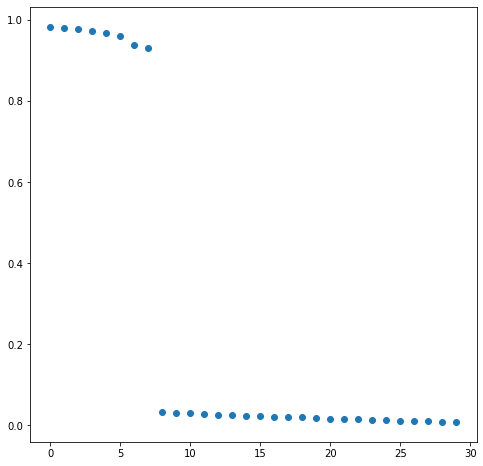

In [10]:
# Plot canonical correlations

fig = plt.figure(figsize=(8,8))

plt.plot(s, 'o')
plt.show()

### Online algorithms

In [11]:
# Parameters

trials = 5; epochs = 1; z_dim = 1; iters = epochs*samples

In [12]:
# Maximum of the objective

max_obj = sum(s[:z_dim])/2

In [13]:
if z_dim==1:
    genoja_err = np.zeros((trials,iters))

biocca_err = np.zeros((trials,iters))
biocca_constraint_err = np.zeros((trials,iters))
msgcca_err = np.zeros((trials,iters))

In [14]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} of out {trials}:')
    
    # Random permutation of the inputs

    idx = np.random.permutation(samples)
    
    # Initialize algorithm
    
    if z_dim==1:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))

    biocca = bio_cca(z_dim,x_dim,y_dim,dataset)    
    biocca_Vx = np.zeros((iters,x_dim,z_dim))
    biocca_Vy = np.zeros((iters,y_dim,z_dim))
        
    # Run online algorithms
    
    print('Running online algorithms...')
    
    for i_iter in range(samples):

        x = X[:,idx[i_iter]]
        y = Y[:,idx[i_iter]]
        
        genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
        biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
        
    # Compute error
                
    print('Computing errors...')

    for i_iter in range(iters):
        if z_dim==1:
            genoja_err[i_trial,i_iter] = error(genoja_vx[i_iter], genoja_vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            
        biocca_err[i_trial,i_iter] = error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
        biocca_constraint_err[i_trial,i_iter] = constraint_error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy)

Trial 1 of out 5:
Running online algorithms...
Computing errors...
Trial 2 of out 5:
Running online algorithms...
Computing errors...
Trial 3 of out 5:
Running online algorithms...
Computing errors...
Trial 4 of out 5:
Running online algorithms...
Computing errors...
Trial 5 of out 5:
Running online algorithms...
Computing errors...


### Comparison plots

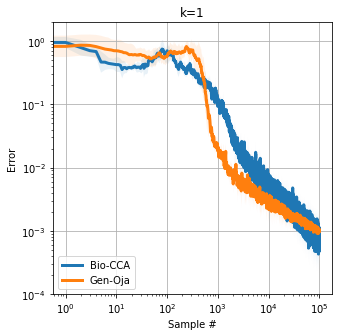

In [15]:
linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, biocca_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-CCA'})

if z_dim==1:
    add_fill_lines(ax, t, genoja_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Gen-Oja'})

ax.loglog()

plt.title(f"k={z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Sample #')
plt.ylabel('Error')

plt.show()